In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch
from transformers import pipeline
from transformers import AutoTokenizer
import numpy as np

import warnings
warnings.filterwarnings("ignore")

/Users/annapetrov/Downloads/study/диплом_мага/final_code_2/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/annapetrov/Downloads/study/диплом_мага/final_code_2/.venv311/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
all_texts = pd.read_csv('/Users/annapetrov/Downloads/study/диплом_мага/final_code/output/smartlab_comments.csv')

In [3]:
stock_name = 'SBER'

In [ ]:
print(all_texts.shape)
all_texts.head()

(45685, 5)


,datetime,text,ticker,author,data-id
0,08.10.2025 20:48,получается 2000 дно будет,SBER,Koshchei,18682912
1,08.10.2025 20:47,"Объем торгов основной сессии (101,6 млрд руб.)...",SBER,Максим,18682903
2,08.10.2025 20:46,"это крах 87 года, по нему идём, начали падать ...",SBER,Koshchei,18682896
3,08.10.2025 20:44,"у меня плохие новости ребят Koshchei, Koshchei...",SBER,Борис Борисов,18682882
4,08.10.2025 20:42,NaN,SBER,Koshchei,18682869


In [ ]:
df = all_texts[all_texts['ticker'] == stock_name]
print(df.shape)
df.head()

(5000, 5)


,datetime,text,ticker,author,data-id
0,08.10.2025 20:48,получается 2000 дно будет,SBER,Koshchei,18682912
1,08.10.2025 20:47,"Объем торгов основной сессии (101,6 млрд руб.)...",SBER,Максим,18682903
2,08.10.2025 20:46,"это крах 87 года, по нему идём, начали падать ...",SBER,Koshchei,18682896
3,08.10.2025 20:44,"у меня плохие новости ребят Koshchei, Koshchei...",SBER,Борис Борисов,18682882
4,08.10.2025 20:42,NaN,SBER,Koshchei,18682869


In [6]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,datetime,text,ticker,author,data-id,sentiment_score,Negative,Neutral,Positive
0,08.10.2025 20:48,получается 2000 дно будет,SBER,Koshchei,18682912,,,,
1,08.10.2025 20:47,"Объем торгов основной сессии (101,6 млрд руб.)...",SBER,Максим,18682903,,,,
2,08.10.2025 20:46,"это крах 87 года, по нему идём, начали падать ...",SBER,Koshchei,18682896,,,,
3,08.10.2025 20:44,"у меня плохие новости ребят Koshchei, Koshchei...",SBER,Борис Борисов,18682882,,,,
4,08.10.2025 20:42,NaN,SBER,Koshchei,18682869,,,,


In [7]:
model_name = "blanchefort/rubert-base-cased-sentiment"

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    framework="pt",
    device=0 if torch.backends.mps.is_available() else -1
)

Device set to use mps:0


In [8]:
def map_sentiment(result):
    neg = neu = pos = 0.0
    
    if result["label"] == "NEGATIVE":
        neg = result["score"]
        compound = -result["score"]
    elif result["label"] == "POSITIVE":
        pos = result["score"]
        compound = result["score"]
    else:  # NEUTRAL
        neu = result["score"]
        compound = 0.0

    return compound, neg, neu, pos

In [9]:
tokenizer = AutoTokenizer.from_pretrained("blanchefort/rubert-base-cased-sentiment")

def chunk_text(text, tokenizer, max_tokens=510):
    tokens = tokenizer(
        text,
        add_special_tokens=False,
        return_attention_mask=False,
        return_token_type_ids=False
    )["input_ids"]

    return [
        tokenizer.decode(tokens[i:i + max_tokens])
        for i in range(0, len(tokens), max_tokens)
    ]

In [10]:
def aggregate_sentiments(results):
    scores = []
    negs, neus, poss = [], [], []

    for res in results:
        compound, neg, neu, pos = map_sentiment(res)
        scores.append(compound)
        negs.append(neg)
        neus.append(neu)
        poss.append(pos)

    return (
        float(np.mean(scores)),
        float(np.mean(negs)),
        float(np.mean(neus)),
        float(np.mean(poss))
    )

In [11]:
%%time

for indx, row in sent_df.iterrows():
    try:
        text = sent_df.loc[indx, "text"]

        if pd.isna(text):
            continue

        text = unicodedata.normalize("NFKD", text)

        chunks = chunk_text(text, tokenizer)

        results = sentiment_analyzer(chunks, batch_size=8)

        compound, neg, neu, pos = aggregate_sentiments(results)

        sent_df.at[indx, "sentiment_score"] = compound
        sent_df.at[indx, "Negative"] = neg
        sent_df.at[indx, "Neutral"] = neu
        sent_df.at[indx, "Positive"] = pos

    except Exception as e:
        print("Ошибка в строке:", indx)
        print(text[:200])
        print(e)
        break

Ошибка в строке: 0
получается 2000 дно будет
name 'unicodedata' is not defined
CPU times: user 2.53 ms, sys: 5.52 ms, total: 8.06 ms
Wall time: 9.17 ms


In [12]:
sent_df.head()

,datetime,text,ticker,author,data-id,sentiment_score,Negative,Neutral,Positive
0,08.10.2025 20:48,получается 2000 дно будет,SBER,Koshchei,18682912,,,,
1,08.10.2025 20:47,"Объем торгов основной сессии (101,6 млрд руб.)...",SBER,Максим,18682903,,,,
2,08.10.2025 20:46,"это крах 87 года, по нему идём, начали падать ...",SBER,Koshchei,18682896,,,,
3,08.10.2025 20:44,"у меня плохие новости ребят Koshchei, Koshchei...",SBER,Борис Борисов,18682882,,,,
4,08.10.2025 20:42,NaN,SBER,Koshchei,18682869,,,,


In [13]:
sent_df["datetime"] = pd.to_datetime(
    sent_df["datetime"],
    format="%d.%m.%Y %H:%M",
    errors="coerce"
)

sent_df["datetime"] = sent_df["datetime"].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'ticker', 'author', 'data-id'])

In [14]:
sent_df.head()

,datetime,text,sentiment_score
0,2025-10-08,получается 2000 дно будет,
1,2025-10-08,"Объем торгов основной сессии (101,6 млрд руб.)...",
2,2025-10-08,"это крах 87 года, по нему идём, начали падать ...",
3,2025-10-08,"у меня плохие новости ребят Koshchei, Koshchei...",
4,2025-10-08,NaN,


In [ ]:
sent_df["sentiment_score"] = pd.to_numeric(
    sent_df["sentiment_score"],
    errors="coerce"
)

post_df = (
    sent_df
    .groupby('datetime', as_index=False)
    ['sentiment_score']
    .mean()
)

print(post_df.shape)

(48, 2)


In [ ]:
post_df.head()

,datetime,sentiment_score
0,2025-10-08,NaN
1,2025-10-09,NaN
2,2025-10-10,NaN
3,2025-10-11,NaN
4,2025-10-12,NaN


In [ ]:
post_df.to_csv('post_df.csv')

In [18]:
all_stocks = pd.read_csv('/Users/annapetrov/Downloads/stock_markets_202601022018.csv')
print(all_stocks.shape)
all_stocks.head()

(2894, 8)


,date,open,close,high,low,value,volume,ticker
0,2025-01-03,280.00,272.25,280.41,271.80,1.185357e+10,43086870.0,SBER
1,2025-01-06,270.88,274.37,274.41,270.07,7.737094e+09,28454750.0,SBER
2,2025-01-08,273.07,277.00,277.87,273.07,7.356165e+09,26634660.0,SBER
3,2025-01-09,276.71,271.80,278.77,270.73,1.449133e+10,52952880.0,SBER
4,2025-01-10,272.31,278.77,279.53,270.27,1.962313e+10,71154220.0,SBER


In [19]:
stock_df = all_stocks[all_stocks['ticker'] == stock_name]
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df['date'] = stock_df['date'].dt.date

In [ ]:
# # ПРОСТАВЛЕНИЕ sentiment_score УДАЛИТЬ ПОТОМ

# import numpy as np

# # дневная доходность
# returns = (final_df['close'] - final_df['open']) / final_df['open']

# # сигмоид + масштабирование (похоже на реальные sentiment-модели)
# sentiment = np.tanh(returns * 8)

# # небольшой шум (соцсети ≠ рынок 1 к 1)
# np.random.seed(42)
# sentiment += np.random.normal(0, 0.05, size=len(sentiment))

# # ограничим диапазон
# final_df['sentiment_score'] = sentiment.clip(-0.6, 0.6)

In [ ]:
final_df = pd.merge(
    stock_df,
    post_df,
    left_on="date",
    right_on="datetime",
    how='left'
)

final_df = final_df.drop(columns=['ticker', 'datetime'])
print(final_df.shape)

(290, 8)


In [22]:
final_df.head()

,date,open,close,high,low,value,volume,sentiment_score
0,2025-01-03,280.00,272.25,280.41,271.80,1.185357e+10,43086870.0,-0.193044
1,2025-01-06,270.88,274.37,274.41,270.07,7.737094e+09,28454750.0,0.095795
2,2025-01-08,273.07,277.00,277.87,273.07,7.356165e+09,26634660.0,0.147014
3,2025-01-09,276.71,271.80,278.77,270.73,1.449133e+10,52952880.0,-0.064856
4,2025-01-10,272.31,278.77,279.53,270.27,1.962313e+10,71154220.0,0.175830


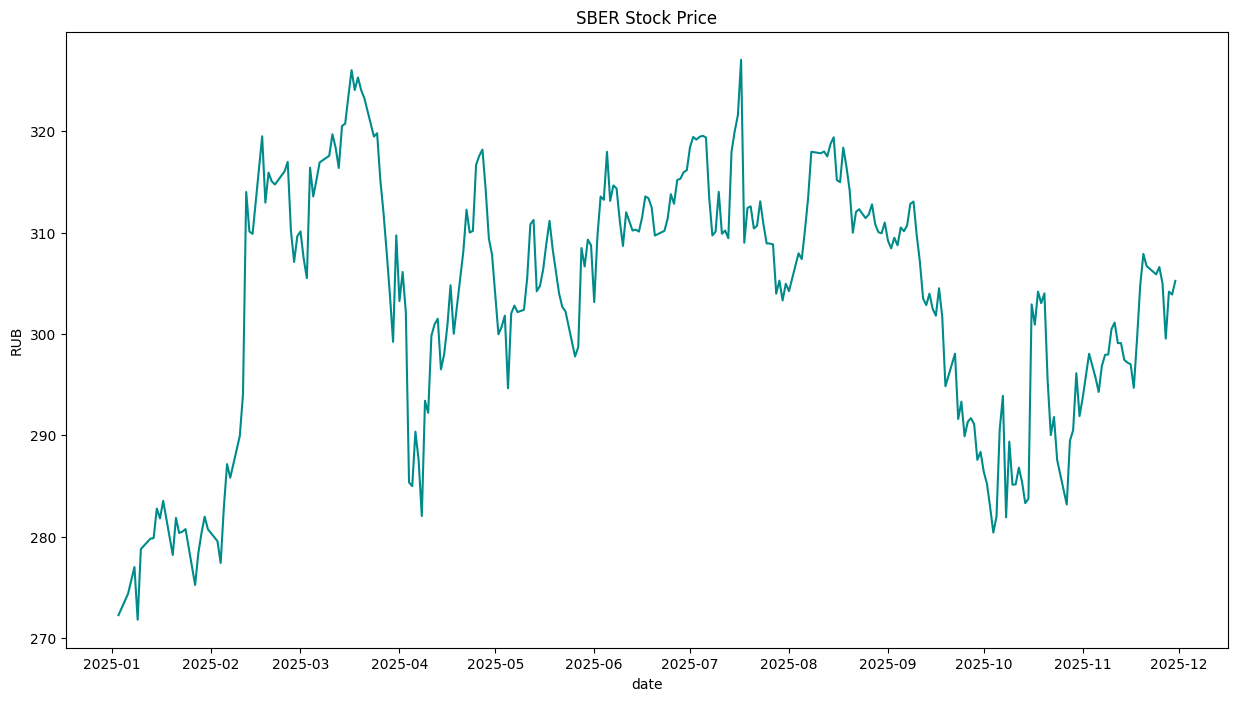

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['date'], final_df['close'], color='#008B8B')
ax.set(xlabel="date", ylabel="RUB", title=f"{stock_name} Stock Price")
plt.show()

In [24]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,2].rolling(window=7).mean()
    data['MA20'] = data.iloc[:,2].rolling(window=20).mean()

    data['MACD'] = data.iloc[:,2].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    data['20SD'] = data.iloc[:, 2].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Exponential moving average
    data['EMA'] = data.iloc[:,2].ewm(com=0.5).mean()

    #  LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,2] - 1)

    return data

In [25]:
final_df.head()

,date,open,close,high,low,value,volume,sentiment_score
0,2025-01-03,280.00,272.25,280.41,271.80,1.185357e+10,43086870.0,-0.193044
1,2025-01-06,270.88,274.37,274.41,270.07,7.737094e+09,28454750.0,0.095795
2,2025-01-08,273.07,277.00,277.87,273.07,7.356165e+09,26634660.0,0.147014
3,2025-01-09,276.71,271.80,278.77,270.73,1.449133e+10,52952880.0,-0.064856
4,2025-01-10,272.31,278.77,279.53,270.27,1.962313e+10,71154220.0,0.175830


In [26]:
final_df.to_csv('final_df.csv')

In [27]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,date,open,close,high,low,value,volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2025-02-03,280.21,279.55,280.35,278.00,8.477126e+09,30373760.0,0.054442,279.561429,279.3755,-0.444687,2.928295,285.232090,273.518910,279.991292,5.629598
1,2025-02-04,279.55,277.40,281.41,275.70,6.685825e+09,23986670.0,-0.072739,279.084286,279.5270,-0.568612,2.727171,284.981343,274.072657,278.263764,5.621849
2,2025-02-05,277.30,282.88,283.89,275.34,1.203512e+10,43070410.0,0.162981,280.177143,279.8210,0.152345,2.757191,285.335383,274.306617,281.341255,5.641481
3,2025-02-06,283.89,287.15,288.92,282.09,1.988558e+10,69363150.0,0.020372,281.434286,280.5885,0.139897,2.534360,285.657220,275.519780,285.213752,5.656516
4,2025-02-07,287.66,285.81,288.90,285.08,7.924869e+09,27626070.0,-0.078623,282.212857,280.9405,-0.531894,2.748355,286.437211,275.443789,285.611251,5.651822


In [28]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['date'], dataset['close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    plt.title('Technical indicators')
    plt.ylabel('Close (RUB)')
    plt.xlabel("Date")
    plt.legend()

    plt.show()

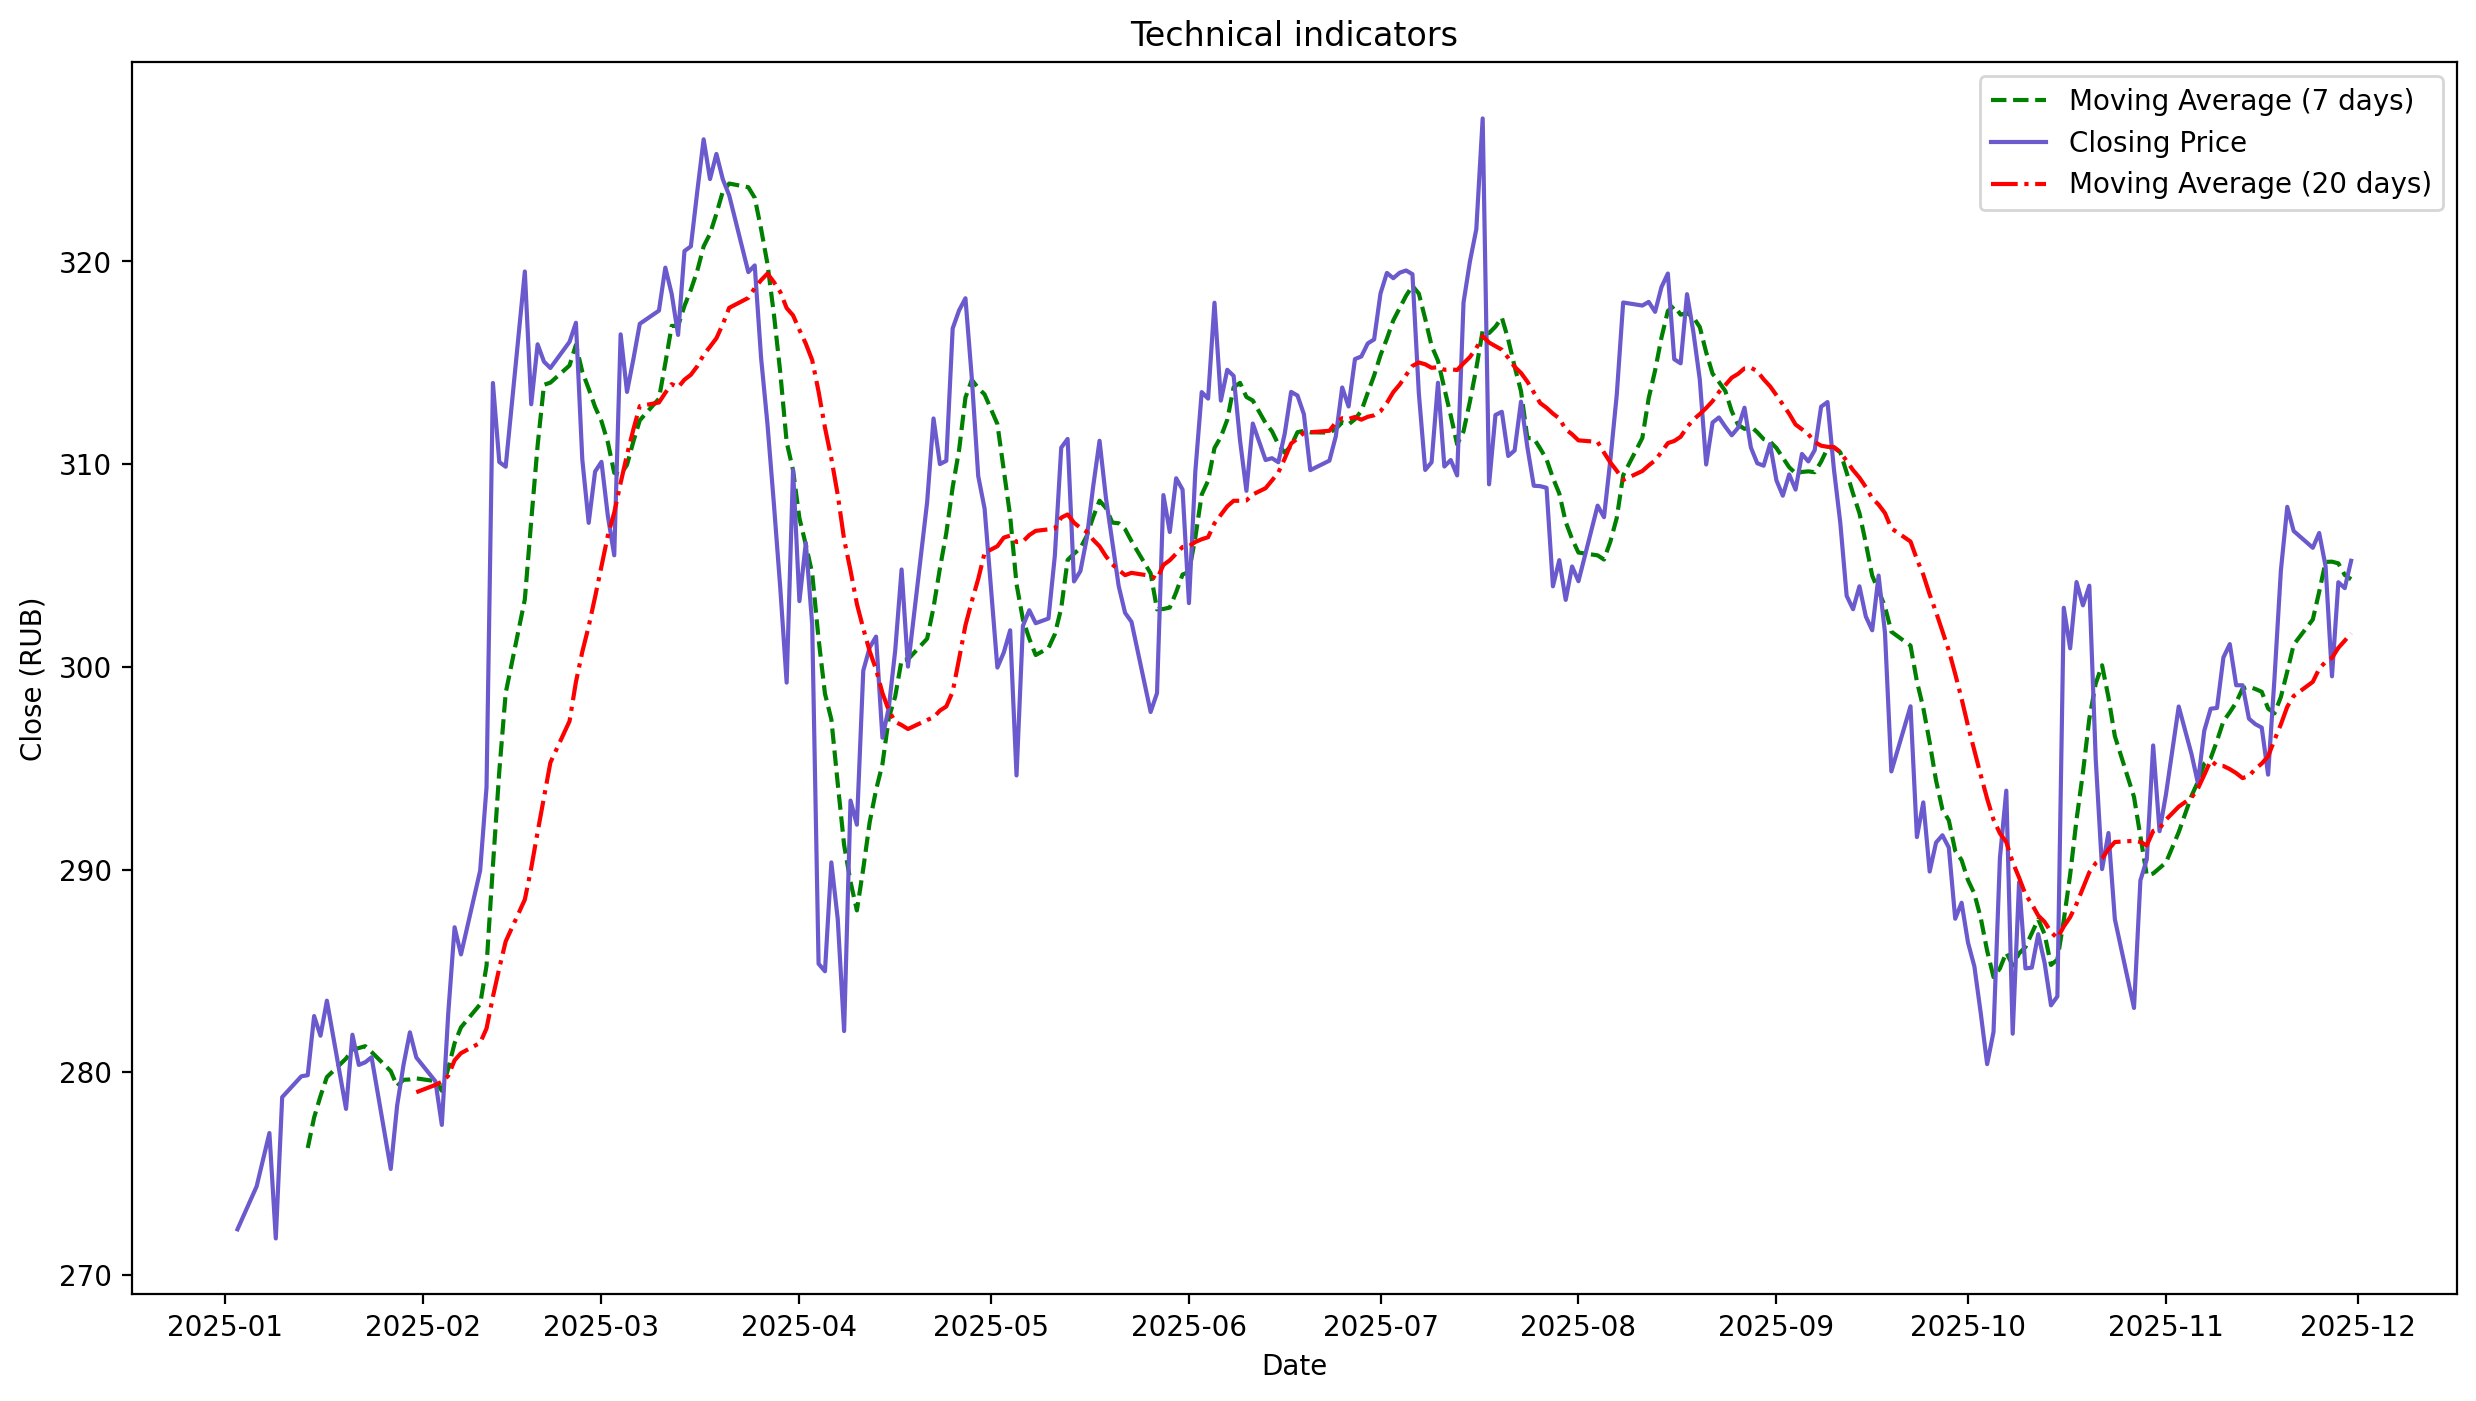

In [29]:
tech_ind(tech_df)